In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and Loading Dataset

In [ ]:
# imports:
import pandas as pd
import numpy as np
import nltk
import pickle
from nltk import classify
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# load cleaned dataset from pickle file
philadelphia_df = pd.read_pickle("/content/drive/MyDrive/UMich Milestone II Project/Final_Code_Submission/Dataset/cleaned_philadelphia_restaurant_reviews.pkl")

# Preprocessing

Getting the data in to the right shape to train the classifiers

In [ ]:
# put tokens into list of dictionaries with words as keys and True as items
tokens = []
for review in philadelphia_df['cleaned_text']:
  tokens.append(dict([token, True] for token in review))

In [ ]:
# create list of tuples of the review token dictionaries and associated star ratings
token_and_label = []
for i in range(len(philadelphia_df)):
   token_and_label.append((tokens[i], philadelphia_df['stars'][i]))

In [ ]:
#CROSS VALIDATION SETS:
n = 130000
sets = []
test = []
train = []
for i in range(5):
  Set = token_and_label[(n-130000):n]
  train_set = Set[:100000]
  test_set = Set[100000:]
  sets.append(Set)
  test.append(test_set)
  train.append(train_set)
  n += 130000
test_reviews = []
test_stars = []
for i in range(len(test)):
  reviews = []
  stars = []
  for j in range(len(test[i])):
    reviews.append(test[i][j][0])
    stars.append(test[i][j][1])
  test_reviews.append(reviews)
  test_stars.append(stars)

In [ ]:
len(train[0])

100000

#Training Models

In [ ]:
# returns mean and standard deviation of evaluation metrics over 5-fold cross validation
def cross_validation(x):
  accuracy = []
  precision = []
  recall = []
  fscore = []
  for i in range(len(train)):
    classif = SklearnClassifier(x).train(train[i])
    a = classify.accuracy(classif, test[i])
    pred = classif.classify_many(test_reviews[i])
    p, r, f, support = precision_recall_fscore_support(y_true=test_stars[i], y_pred=pred, average='weighted')
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
  return {'accuracy': (np.mean(accuracy), np.std(accuracy)),
          'precision': (np.mean(precision), np.std(precision)),
          'recall': (np.mean(recall), np.std(recall)),
          'f-score': (np.mean(fscore), np.std(fscore))}

Naive Bayes Classifier

In [ ]:
MNB = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('nb', MultinomialNB())])
cross_validation(MNB)

{'accuracy': (0.50526, 0.024933755789647457),
 'precision': (0.4685001951131782, 0.020133645695522565),
 'recall': (0.50526, 0.024933755789647457),
 'f-score': (0.4305600570575564, 0.028477104833577325)}

Decision Tree Classifier

In [ ]:
tree = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('dc', DecisionTreeClassifier(random_state=42))])
cross_validation(tree)

{'accuracy': (0.4297066666666667, 0.00766482296671691),
 'precision': (0.42327616900234866, 0.012361981757939507),
 'recall': (0.4297066666666667, 0.00766482296671691),
 'f-score': (0.42576786426234864, 0.010429952871138912)}

Random Forest Classifier

In [18]:
rf = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('rfc', RandomForestClassifier(random_state=42))])
cross_validation(rf)

{'accuracy': (0.5422333333333335, 0.016348306062436903),
 'precision': (0.5195400337648672, 0.014415262212295735),
 'recall': (0.5422333333333335, 0.016348306062436903),
 'f-score': (0.5055137266652426, 0.019173804559381603)}

Logistic Regression

In [ ]:
lr = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('lr', LogisticRegression(random_state=42))])
cross_validation(lr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'accuracy': (0.59996, 0.013977925454086557),
 'precision': (0.5855662839646222, 0.013835442430119662),
 'recall': (0.59996, 0.013977925454086557),
 'f-score': (0.5868603681106237, 0.015136392631529348)}

# Hyperparameter Tuning

In [ ]:
# create models using different "solver" hyperparameters and save best:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
bestsolver, bestaccuracy = None, 0
for solver in solvers:
  pipe = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('reg', LogisticRegression(solver=solver,
                                    random_state=42,
                                    max_iter = 300))])
  eval = cross_validation(pipe)
  acc = eval['accuracy'][0]

  print("Solver: ", solver, " Accuracy: ", acc)
  if acc > bestaccuracy:
    bestaccuracy = acc
    bestsolver = solver
print(bestsolver, bestaccuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Solver:  lbfgs  Accuracy:  0.6003200000000001
Solver:  liblinear  Accuracy:  0.5913
Solver:  newton-cg  Accuracy:  0.6003133333333334
Solver:  sag  Accuracy:  0.6003000000000001
Solver:  saga  Accuracy:  0.6003000000000001
lbfgs 0.6003200000000001


The most accurate solver was 'lbfgs' so we will use that.

In [ ]:
# try different penalties:
bestpenalty = None

for penalty in ['l2', None]:
  pipe = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('reg', LogisticRegression(solver=bestsolver,
                                    penalty=penalty,
                                    random_state=42,
                                    max_iter = 300))])
  eval = cross_validation(pipe)
  acc = eval['accuracy'][0]

  print("Penalty: ", penalty, " Accuracy: ", acc)
  if acc >= bestaccuracy:
    bestaccuracy = acc

    bestpenalty = penalty
print(bestpenalty, bestaccuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Penalty:  l2  Accuracy:  0.6003200000000001


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Penalty:  None  Accuracy:  0.5998666666666665
l2 0.6003200000000001


The most accurate penalty was l2.

In [ ]:
# does increasing 'C' improve performance?
# default C = 1, lets start by increasing to 10
pipe = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('reg', LogisticRegression(solver=bestsolver,
                                    penalty=bestpenalty,
                                    C=10,
                                    random_state=42,
                                    max_iter = 300))])

eval_c10 = cross_validation(pipe)
acc_c10 = eval_c10['accuracy'][0]
print("C: 10 Accuracy: ", acc_c10)

bestc = 1
if acc_c10 > bestaccuracy:
  bestaccuracy = acc_c10
  bestc = 10
print(bestc, bestaccuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

C: 10 Accuracy:  0.601
10 0.601


In [ ]:
# does increasing 'C' improve performance?
# default C = 1, lets start by increasing to 10
pipe = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('reg', LogisticRegression(solver=bestsolver,
                                    penalty=bestpenalty,
                                    C=100,
                                    random_state=42,
                                    max_iter = 300))])
eval_c100 = cross_validation(pipe)
acc_c100 = eval_c100['accuracy'][0]
#reg_c10 =  SklearnClassifier(LogisticRegression(solver=bestsolver,
                                          #    penalty=bestpenalty,
                                          #    C=10,
                                          #    max_iter = 300)).train(train[0])
#acc_c10 = classify.accuracy(reg_c10, test[0])
print("C: 100 Accuracy: ", acc_c100)
if acc_c100 > bestaccuracy:
  bestaccuracy = acc_c100
  #bestmodel = reg_c10
  bestc = 100
print(bestc, bestaccuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

C: 100 Accuracy:  0.6002466666666667
10 0.601


C = 10 has better accuracy than C = 1 or C=100.

In [ ]:
# default class_weight is None, try 'balanced'
pipe = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('reg', LogisticRegression(solver=bestsolver,
                                    penalty=bestpenalty,
                                    C=bestc,
                                    class_weight='balanced',
                                    random_state=42,
                                    max_iter = 300))])
eval_balanced = cross_validation(pipe)
acc_balanced = eval_balanced['accuracy'][0]
print("class_weight: balanced Accuracy: ", acc_balanced)
bestweight = None
if acc_balanced > bestaccuracy:
  bestaccuracy = acc_balanced
  bestweight = 'balanced'
print(bestweight, bestaccuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

class_weight: balanced Accuracy:  0.5815133333333333
None 0.601


class_weight = None has better accuracy than class_weight = 'balanced'

After hyperparameter tuning, our best model is the model where solver = 'liblinear', penalty = 'l1', C = 1, and class_weight = None.

In [ ]:
# cross validation with final hyperparameters for results reporting
pipeline = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('nb', LogisticRegression(solver = bestsolver,
                                              penalty=bestpenalty,
                                              C=bestc,
                                              class_weight=bestweight,
                                              random_state=42,
                                              max_iter=1000
                                              ))])
cross_validation(pipeline)

{'accuracy': (0.6011533333333332, 0.014103657524045146),
 'precision': (0.5881431140392591, 0.014489910655027777),
 'recall': (0.6011533333333332, 0.014103657524045146),
 'f-score': (0.5906566382894641, 0.015262140821963453)}

# Failure Analysis

Model for Failure Analysis

In [ ]:
#larger test and training sets
train_set = token_and_label[:500000]
test_set = token_and_label[500000:]
reviews = []
stars = []
for j in range(len(test_set)):
  reviews.append(test_set[j][0])
  stars.append(test_set[j][1])

In [ ]:
bestsolver, bestpenalty, bestc, bestweight = ('lbfgs', 'l2', 10, None)

In [ ]:
pipeline = Pipeline([('tfidf', TfidfTransformer()),
                    ('chi2', SelectKBest(chi2, k=1000)),
                    ('nb', LogisticRegression(solver = bestsolver,
                                              penalty=bestpenalty,
                                              C=bestc,
                                              class_weight=bestweight,
                                              random_state=42,
                                              max_iter=1500
                                              ))])
LR = SklearnClassifier(pipeline).train(train_set)
accuracy = classify.accuracy(LR, test_set)
pred = LR.classify_many(reviews)
precision, recall, fscore, support = precision_recall_fscore_support(y_true=stars, y_pred=pred, average='weighted')
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print('Recall', recall)
print("F-score: ", fscore)

Accuracy:  0.6280027123856713
Precision:  0.6148666705505378
Recall 0.6280027123856713
F-score:  0.6187294633348176


In [ ]:
#create dataframe of reviews, actual star ratings, and predicted star ratings
df = pd.DataFrame(list(zip(reviews, stars, pred)), columns = ['reviews', 'true_stars', 'predicted_stars']).query('true_stars != predicted_stars')
df.head()

,reviews,true_stars,predicted_stars
0,"{'fair': True, 'beer': True, 'select': True, '...",3,4
3,"{'big': True, 'fan': True, 'place': True, 'exc...",5,4
7,"{'live': True, 'minut': True, 'away': True, 'a...",4,3
9,"{'cycl': True, 'new': True, 'jersey': True, 't...",4,5
10,"{'cheap': True, 'quick': True, 'delici': True,...",5,4


[Text(0.5, 1.0, 'Frequency of Types of Error')]

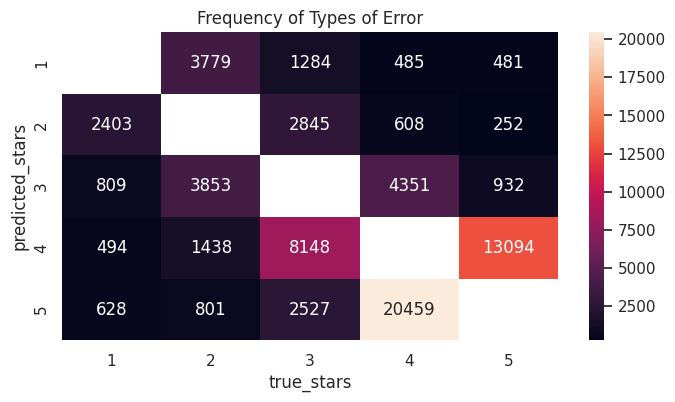

In [ ]:
import seaborn as sns
freq = df[['true_stars', 'predicted_stars']].groupby(['predicted_stars', 'true_stars']).value_counts().unstack()
sns.set(rc={"figure.figsize":(8, 4), 'axes.facecolor':'white'})
sns.heatmap(freq, annot=True, fmt = 'g').set(title='Frequency of Types of Error')

In [ ]:
print(freq)

true_stars            1       2       3        4        5
predicted_stars                                          
1                   NaN  3779.0  1284.0    485.0    481.0
2                2403.0     NaN  2845.0    608.0    252.0
3                 809.0  3853.0     NaN   4351.0    932.0
4                 494.0  1438.0  8148.0      NaN  13094.0
5                 628.0   801.0  2527.0  20459.0      NaN


The most common errors are reviews being predicted as the star rating one above or one below the correct star rating, especially with true 4s being predicted as 5s, true 5s being predicted as 4s, and true 3s being predicted as 4s.

In [ ]:
df2 = df.query('true_stars == 4 & predicted_stars == 5')
words = []
for i in range(len(df2)):
  for word in list(df2.reset_index()['reviews'][i].keys()):
    words.append(word)
from collections import Counter
counts = Counter(words)
sorted(counts.items(),key=lambda item:item[1], reverse=True)[:10]

[('food', 8277),
 ('great', 8110),
 ('place', 8109),
 ("'s", 7373),
 ('good', 7040),
 ("n't", 6717),
 ('delici', 5452),
 ('love', 5092),
 ('go', 5043),
 ('time', 4922)]

In [ ]:
df3 = df.query('true_stars == 5 & predicted_stars == 4')
words2 = []
for i in range(len(df3)):
  for word in list(df3.reset_index()['reviews'][i].keys()):
    words2.append(word)
from collections import Counter
counts2 = Counter(words2)
sorted(counts2.items(),key=lambda item:item[1], reverse=True)[:10]

[('good', 7166),
 ('food', 6169),
 ('place', 6012),
 ("'s", 5623),
 ("n't", 5421),
 ('great', 5406),
 ('like', 4223),
 ('get', 3898),
 ('time', 3780),
 ('order', 3777)]

# Feature Importance

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract features and labels from the training set
train_features = []
for features, label in train_set:
    train_features.append(features)
train_labels = []
for features, label in train_set:
    train_labels.append(label)

# Extracting texts from the train_features
train_texts = []
for features in train_features:
    text = ' '.join(list(features.keys()))
    train_texts.append(text)

In [ ]:
# Fit model
tfidf_vectorizer = TfidfVectorizer()
train_vectors = tfidf_vectorizer.fit_transform(train_texts)

best_lr_model = LogisticRegression(solver='liblinear', penalty='l1', C=1, class_weight=None, max_iter=1000)
pipeline = Pipeline([('tfidf', TfidfTransformer()),
                     ('chi2', SelectKBest(chi2, k=1000)),
                     ('lr', best_lr_model)])

In [ ]:
pipeline.fit(train_vectors, train_labels)

In [ ]:
# Extract feature names
selected_features = pipeline.named_steps['chi2'].get_support(indices=True)
feature_names = tfidf_vectorizer.get_feature_names_out()
selected_feature_names = [feature_names[i] for i in selected_features]

# Feature coeffs from model
coefficients = pipeline.named_steps['lr'].coef_[0]

# Dictionary for feature names and their coeffs
feature_coefficients = dict(zip(selected_feature_names, abs(coefficients)))
sorted_feature_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

In [ ]:
top = 20
for feature, coefficient in sorted_feature_coefficients[:top]:
    print(f"{feature}: {coefficient}")

In [ ]:
import matplotlib.pyplot as plt

# Sort features by their absolute coefficients (feature importance)
sorted_feature_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

# Extract feature names and coefficients
top_features = [feature for feature, _ in sorted_feature_coefficients[:top]]
top_coefficients = [coefficient for _, coefficient in sorted_feature_coefficients[:top]]

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_coefficients, color='lightblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top Features and Coefficients')
plt.gca().invert_yaxis()
plt.show()